# Document search with embeddings

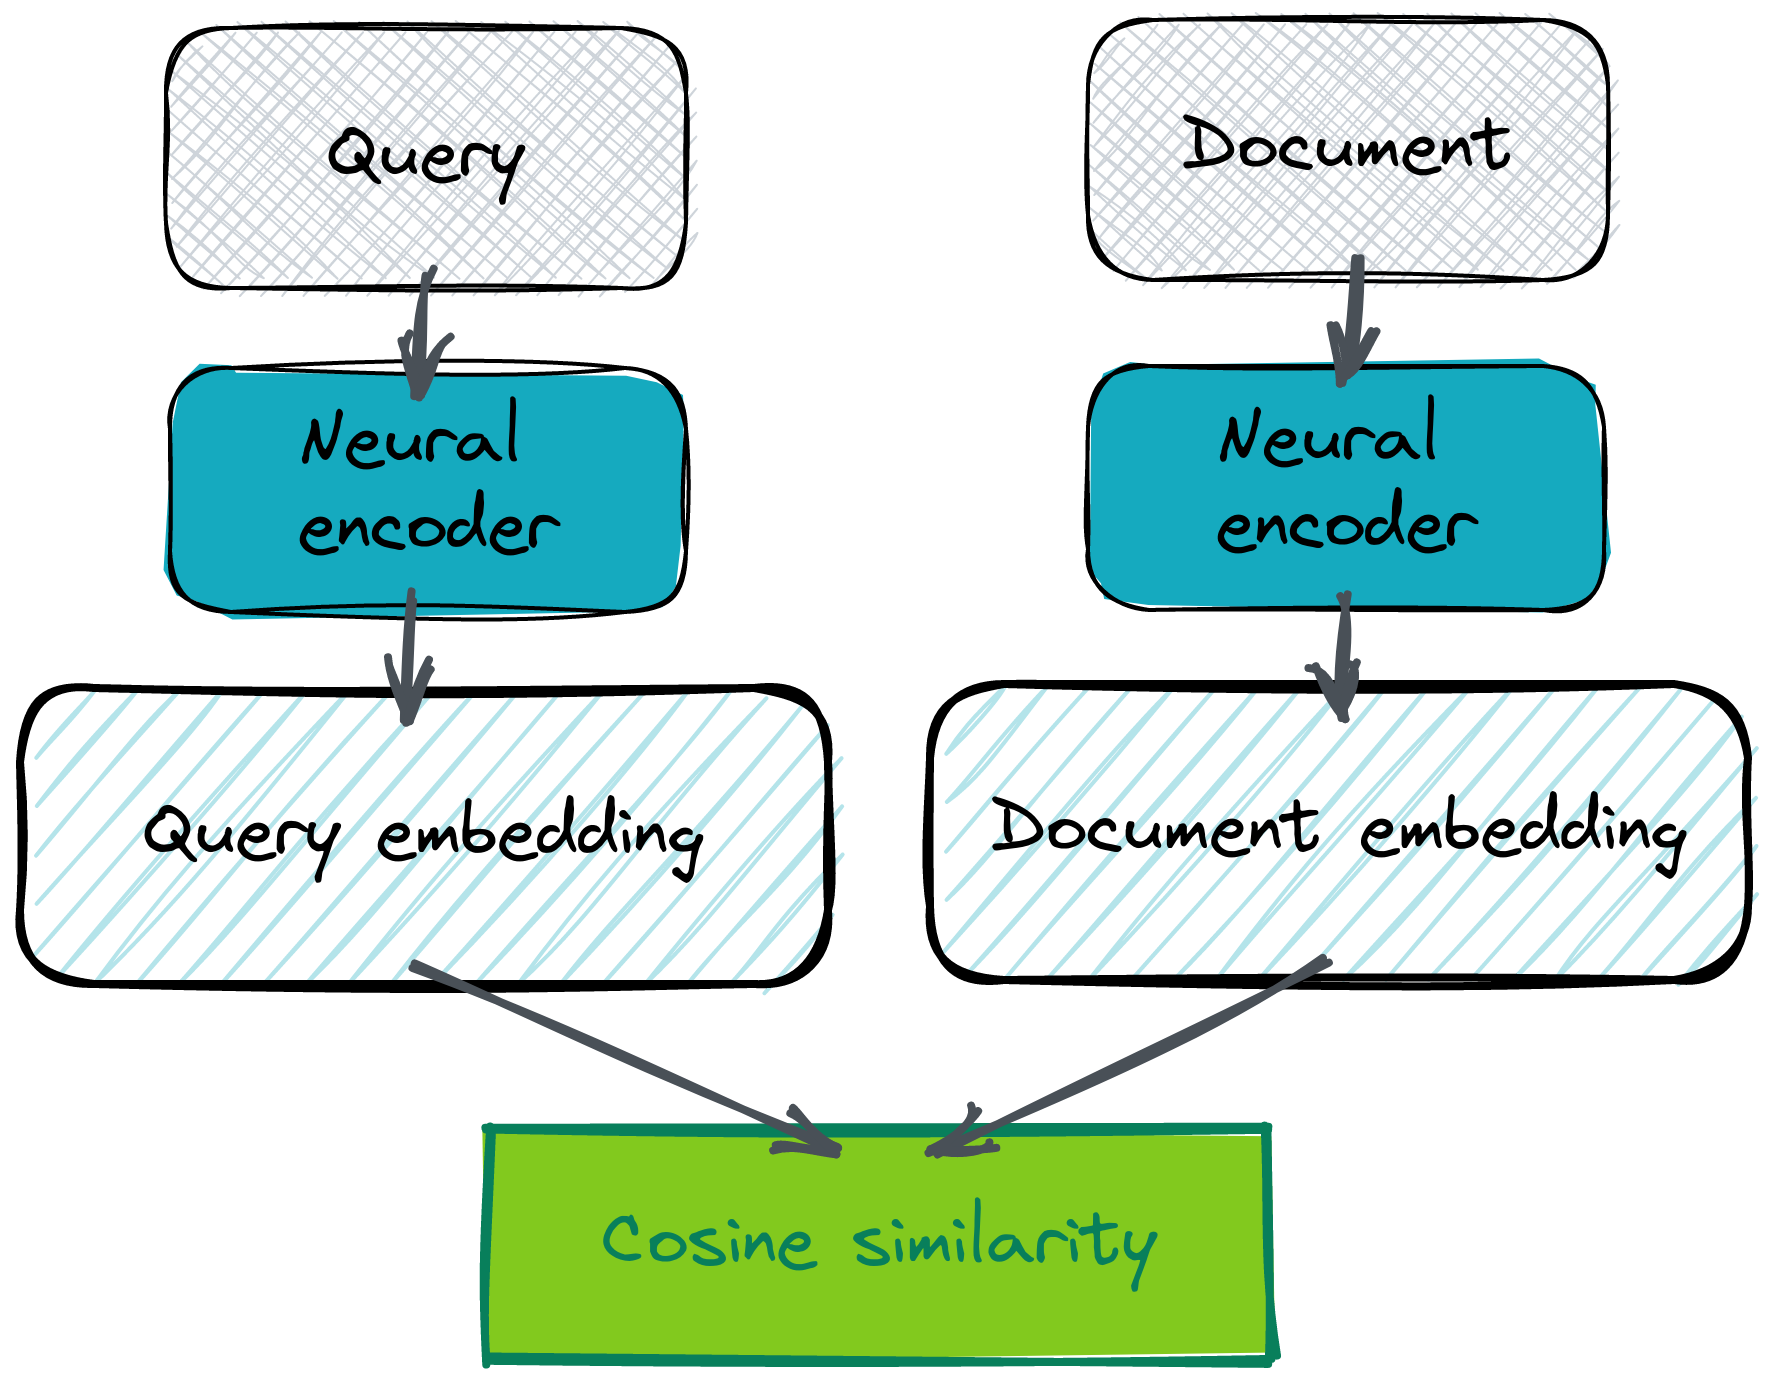

In [2]:
import google.generativeai as genai
from dotenv import load_dotenv
import os

def configure_access():
    load_dotenv()  # Load environment variables from .env file
    google_credentials = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    api_key = os.getenv('GOOGLE_API_KEY')
    if not api_key:
        raise ValueError("API key not found in environment variables")

    return api_key

api_key=configure_access()

for m in genai.list_models():
    if 'embedContent' in m.supported_generation_methods:
        print(m.name)



models/embedding-001
models/text-embedding-004


In [3]:
title = "The next generation of AI for developers and Google Workspace"
sample_text = ("Title: The next generation of AI for developers and Google Workspace"
    "\n"
    "Full article:\n"
    "\n"
    "Gemini API & Google AI Studio: An approachable way to explore and prototype with generative AI applications")

model = 'models/embedding-001'
embedding = genai.embed_content(model=model,
                                content=sample_text,
                                task_type="retrieval_document",
                                title=title)

print(embedding)

{'embedding': [0.03411343, -0.05517662, -0.020209055, -0.0041249567, 0.058917783, 0.014129515, 0.0045353593, 0.0014303668, 0.05976634, 0.08292115, 0.007162964, 0.0069041685, -0.053083427, -0.010905125, 0.0321402, -0.037163995, 0.050372455, 0.019348344, -0.037328612, 0.026647927, 0.030781753, -0.011288501, -0.031485256, -0.060248993, -0.026219442, -0.009794235, 0.006630139, -0.01846516, -0.026324715, 0.020442624, -0.06317684, 0.014559574, -0.052296035, 0.016451128, -9.720217e-05, -0.051706687, -0.0054406044, -0.056967627, 0.011144145, -0.009201792, -0.0021951047, -0.1099701, -0.011712193, 0.021221714, 0.009171804, -0.029621972, 0.034534883, 0.039578073, 0.019021519, -0.06269169, 0.039473332, 0.052403256, 0.061814185, -0.034507945, -0.009557816, -0.0049551064, 0.017839009, -0.021176832, 0.015043588, 0.015390569, -0.006334281, 0.043696404, -0.028341983, 0.028433999, 0.01472686, -0.06585564, -0.044533554, 0.0055523133, 0.035775978, 0.031099156, 0.027357662, 0.028062241, 0.056972917, -0.054

In [4]:
len(embedding['embedding'])

768

In [6]:
DOCUMENT1 = {
    "title": "Operating the Climate Control System",
    "content": "Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console.  Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the car. Heat: The car will blow warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it."}
DOCUMENT2 = {
    "title": "Touchscreen",
    "content": "Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the \"Navigation\" icon to get directions to your destination or touch the \"Music\" icon to play your favorite songs."}
DOCUMENT3 = {
    "title": "Shifting Gears",
    "content": "Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions."}

documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3]

In [7]:
documents

[{'title': 'Operating the Climate Control System',
  'content': 'Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console.  Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the

In [8]:
import pandas as pd
df = pd.DataFrame(documents)
df.columns = ['Title', 'Text']
df

,Title,Text
0,Operating the Climate Control System,Your Googlecar has a climate control system th...
1,Touchscreen,Your Googlecar has a large touchscreen display...
2,Shifting Gears,Your Googlecar has an automatic transmission. ...


In [9]:
# Get the embeddings of each text and add to an embeddings column in the dataframe
def embed_fn(title, text):
    return genai.embed_content(model=model,
                             content=text,
                             task_type="retrieval_document",
                             title=title)["embedding"]

df['Embeddings'] = df.apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
df

,Title,Text,Embeddings
0,Operating the Climate Control System,Your Googlecar has a climate control system th...,"[-0.033361107, -0.021217084, -0.049581926, -0...."
1,Touchscreen,Your Googlecar has a large touchscreen display...,"[0.009660736, -0.030662702, -0.017281422, -0.0..."
2,Shifting Gears,Your Googlecar has an automatic transmission. ...,"[-0.04270796, -0.007160868, -0.03242516, -0.02..."


In [10]:
import numpy as np
def find_best_passage(query, dataframe):
    """
    Compute the distances between the query and each document in the dataframe
    using the dot product.
    """
    query_embedding = genai.embed_content(model=model,
                                        content=query,
                                        task_type="retrieval_query")
    dot_products = np.dot(np.stack(dataframe['Embeddings']), query_embedding["embedding"])
    idx = np.argmax(dot_products)
    return dataframe.iloc[idx]['Text'] # Return text from index with max value

In [11]:
query = "How do you shift gears in the Google car?"
passage = find_best_passage(query, df)
passage

'Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions.'

# Exercise

In [16]:
import pandas as pd
DOCUMENT_PHY = {
    "title": "Physics Subject",
    "content": "Physics is the natural science that studies matter, energy, and the fundamental forces of nature. It explores the behavior and interactions of particles and waves, from the smallest subatomic particles to the largest galaxies. Physics seeks to understand the underlying principles governing the universe through theories and experiments. Key areas include mechanics, electromagnetism, thermodynamics, and quantum mechanics. It forms the basis for many technological advancements and contributes to our understanding of the cosmos."}
DOCUMENT_CHE = {
    "title": "Chemistry Subject",
    "content": "Chemistry is the scientific study of matter, its properties, and how substances interact and change. It includes branches like organic chemistry, which focuses on carbon compounds, and inorganic chemistry, which deals with non-organic substances. Physical chemistry explores the physical properties of molecules, while analytical chemistry involves analyzing material samples to understand their composition. Chemistry is fundamental in various fields, including medicine, environmental science, and industrial applications."}
DOCUMENT_MATHS = {
    "title": "Maths - Mathematics Subject",
    "content": "Mathematics is the study of numbers, quantities, shapes, and patterns, and their relationships and properties. It includes various branches such as algebra, which deals with equations and variables, and geometry, which focuses on shapes and their properties. Calculus explores change and motion through derivatives and integrals. Statistics involves the analysis and interpretation of data. Mathematics is essential in science, engineering, finance, and many other fields."}

documents_ex = [DOCUMENT_PHY, DOCUMENT_CHE, DOCUMENT_MATHS]
df_ex = pd.DataFrame(documents_ex)
df_ex

,title,content
0,Physics Subject,Physics is the natural science that studies ma...
1,Chemistry Subject,"Chemistry is the scientific study of matter, i..."
2,Maths - Mathematics Subject,"Mathematics is the study of numbers, quantitie..."


In [17]:
df_ex.columns = ['Title', 'Text']
def embed_fn(title, text):
    return genai.embed_content(model=model,
                             content=text,
                             task_type="retrieval_document",
                             title=title)["embedding"]

df_ex['Embeddings'] = df_ex.apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)
df_ex

,Title,Text,Embeddings
0,Physics Subject,Physics is the natural science that studies ma...,"[0.034576014, -0.009514278, -0.02068438, -0.00..."
1,Chemistry Subject,"Chemistry is the scientific study of matter, i...","[0.020030161, -0.0042754565, -0.025904747, -0...."
2,Maths - Mathematics Subject,"Mathematics is the study of numbers, quantitie...","[0.022826016, -0.02209921, -0.0002323598, 0.00..."


In [18]:
import numpy as np
def find_best_passage(query, dataframe):
    """
    Compute the distances between the query and each document in the dataframe
    using the dot product.
    """
    query_embedding = genai.embed_content(model=model,
                                        content=query,
                                        task_type="retrieval_query")
    dot_products = np.dot(np.stack(dataframe['Embeddings']), query_embedding["embedding"])
    idx = np.argmax(dot_products)
    return dataframe.iloc[idx]['Text'] # Return text from index with max value

query = "What is the oxygen?"
passage = find_best_passage(query, df_ex)
passage

'Chemistry is the scientific study of matter, its properties, and how substances interact and change. It includes branches like organic chemistry, which focuses on carbon compounds, and inorganic chemistry, which deals with non-organic substances. Physical chemistry explores the physical properties of molecules, while analytical chemistry involves analyzing material samples to understand their composition. Chemistry is fundamental in various fields, including medicine, environmental science, and industrial applications.'